In [3]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv()

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_ENDPOINT")
_set_env("LANGSMITH_API_KEY")
_set_env("LANGSMITH_PROJECT")
_set_env("TAVILY_API_KEY")

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str


graph_builder = StateGraph(AgentState)

In [6]:
# retriever 노드
def retrieve(state: AgentState):
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")


In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

# answer 노드
def generate(state: AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({"context": context, "question": query})
    return {"answer": response}

In [9]:
from langchain import hub
from typing import Literal

relevence_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

# 문서 관련성 체크 노드
def check_relevence_doc(state: AgentState) -> Literal["relevant", "irrelevant"]:
    query = state["query"]
    context = state["context"]

    relevence_chain  = relevence_doc_prompt | llm 
    response = relevence_chain.invoke({"documents": context, "question": query})
    print(f"dec relevence response: {response}")

    
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'

In [10]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template(
"""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요.
사용자의 질문 : {query}
"""
)

def rewrite(state: AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [11]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    return {"context": results}

In [12]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("web_search", web_search)


In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_relevence_doc, {
  "relevant": "generate",
  "irrelevant": "rewrite"
})
graph_builder.add_edge("rewrite", "web_search")
graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

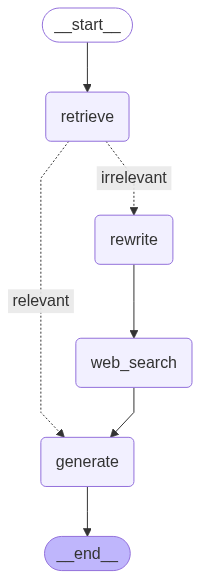

In [14]:
from IPython.display import Image, display

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initail_state = {
  "query": "연봉 5천만원 거주자의 소득세는 얼마인가요?"
}
graph.invoke(initail_state)

dec relevence response: {'Score': 1, 'Explanation': "To determine if the provided FACTS are related to the QUESTION, I need to check if there are keywords or content that discuss the calculation of income tax, particularly for the context of a resident with an annual income of 50 million won.\n\n1. The first document contains specific details about income tax laws, conditions for deductions, tax rates, and tax calculations based on different income brackets. It includes a table with different income brackets and applicable tax rates for each. The information here is relevant as it provides the specific tax rates for various income levels, including those potentially relevant to an annual income of 50 million won.\n   - For example, it mentions a bracket for income over 1,400만원 and their respective tax calculations, which would apply to someone earning 50 million.\n\n2. The second document talks about tax calculations related to other scenarios like property sales and other special case

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='30d76fab-2884-47d1-a9da-a55bd1fd2b79', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 20

In [16]:
initail_state = {
  "query": "판교 맛집을 추천해주세요."
}
graph.invoke(initail_state)

dec relevence response: {'Score': 0, 'Explanation': "To determine the relevance of the FACTS provided, we need to analyze if they contain any keywords or semantic meaning related to the QUESTION, '판교 맛집을 추천해주세요' which translates to 'Please recommend a good restaurant in Pangyo.' The FACTS are focused exclusively on aspects of income tax legislation, specifically dealing with transfer income tax standards, land transaction contracts, and other tax law complexities. There are no mentions of restaurants, food, or any cultural and lifestyle references related to Pangyo that would indirectly pertain to restaurant recommendations. Since the FACTS do not contain any information related to 'restaurants,' 'Pangyo,' or any associated keywords that would link them to the context of dining or eateries, they are entirely unrelated to the QUESTION. Therefore, the score assigned is 0, indicating a complete lack of connection to the QUESTION."}


{'query': '"판교 지역 인기 맛집 추천 리스트"',
 'context': [{'title': '판교 맛집 추천 베스트 11 | 판교역 점심 저녁 | 성남 숨은맛집 리스트',
   'url': 'https://forourtour.com/판교-맛집/',
   'content': '판교는 테크노밸리 등의 기업들이 모여있는 중심지로 많은 기업들과 직장인들로 붐비는 대표적인 기업 도시입니다. 판교 맛집에는 이가네양갈비 판교점, 다이호시, 파파라구, 울프스덴, 화포식당 판교점, 까몬 판교아브뉴프랑점, 데이빗앤룰스, 정희 판교아브뉴프랑점, 마키노차야 판교점, 인디테이블, 양산도 판교점 등이 있습니다. 관련 검색어에는 경기도 성남 분당구 판교 맛집 추천 음식점 숨은맛집 리스트 지도 판교역 인근 현지인 가성비 양식 한식 뷔페 데이트코스 분위기 입니다.\n\nImage 2: 판교 맛집 추천\n\n판교 맛집 리스트 모음\n------------\n\n판교 맛집에는 이가네양갈비 판교점, 다이호시, 파파라구, 울프스덴, 화포식당 판교점, 까몬 판교아브뉴프랑점, 데이빗앤룰스, 정희 판교아브뉴프랑점, 마키노차야 판교점, 인디테이블, 양산도 판교점이 있습니다. 본문 내용에서 판교 맛집들의 자세한 정보를 알아보세요. [...] Table of Contents\n-----------------\n\n   판교 맛집 리스트 모음\n   이가네양갈비 판교점: 판교 저녁 맛집 – 거리뷰 바로가기\n   다이호시: 판교 맛집 추천 – 인스타 바로가기\n   파파라구: 판교 양식 맛집 – 인스타 바로가기\n   울프스덴: 판교 점심 추천 – 인스타 바로가기\n   화포식당 판교점: 판교 저녁 맛집 – 거리뷰 바로가기\n   까몬 판교아브뉴프랑점: 판교 점심 맛집 – 인스타 바로가기\n   데이빗앤룰스: 판교 맛집 추천 – 인스타 바로가기\n   정희 판교아브뉴프랑점: 분당 판교 맛집 – 거리뷰 바로가기\n   마키노차야 판교점: 판교 뷔페 추천 – 거리뷰 바로가기\n   인디테이블: 판교 점